# Using Gaussian Mixture Models to Isolate Movement in Video

### Experiments in removing the background from video from scratch

## Description

---

OpenCV has an algorithm `createBackgroundSubtractorMOG2` that allows you to create a background model from a video which you can then use to create a mask that isolates just the moving parts of that same video.

Under the hood, it uses Gaussian Mixture Models (GMMs) to build up a distribution of color values at each pixel for a subsample of frames (this can be adjusted withe the `history` parameter of the method)

To better understand this algorithm and Gaussian Mixture Models better, I attempt remove the background from a short clip of traffic moving down a highway.

<img src="./assets/traffic.gif" width=300 />

## Methods

---

To remove the background, I first create a model of it by initializing a GMM for each pixel in a the frame of a video. This is a relitivly short video so I will not be subsampling frames to build the history that represents the background, rather I will be using all the frames.

Each GMM is fit to the RGB pixel values as they change through each frame of the video. We can then detect anomolies be scoring new pixel values with each model. For example, below you can see every RGB value for a specific pixel scored with the associated GMM. Very yellow points are outliers and will be considered bright and moving in the frame they appear in

<img src="./assets/scatter1.png" width=300 />

All the points in a single frame can be evaluated in the same way, which yeilds a result like below, where yellow areas indicate movement and purple areas indicate background

<img src="./assets/frame1.png" width=300 />

## Results

---
### From Scratch Implementation:

<img src="./assets/traffic_movement_scratch.gif" width=300 />

---
### OpenCV algorithm:

<img src="./assets/traffic_movement.gif" width=300 />

While I am impressed by the results I was able to achieve from scratch, the OpenCV  implementation has some distinct advantages:
- It is much faster, the 8 second video was processed in less than a second. While I'm sure speed is dependent on frame size and resolution, the OpenCV algorithm could be used for real-time applications.
- Can work on-line, the OpenCV implementation allows you to build up a background model frame by frame as they become available. Again suited well for real-time applications.
- Allows you to specify a history length. Old frames are thrown out and removed form the model after a certain number of frames have accumulated. This has the effect of ignoring, after some time, parts of a video that were once moving but then became stationary.
- OpenCV implementation can differentiat shadows and can remove them entirely if desired

There appears to be artifacts that flash in front of the entire video of the OpenCV implementation that are not preseent on the scratch implementation. These could be reduced by increasing the threshold value passed into `createBackgroundSubtractorMOG2`

One fun thing that I can do with my scratch implementation is take the average pixel value from each GMM and build up an image of just the background, excluding all moving parts of the video.

<img src="./assets/bg.png" width=300>

Even though my approach won't be used in production anytime soon, it was very interesting and educational to dive into this algorithm more in-depth and use GMMs in a way that I would not have otherwise considered.



In [182]:
from IPython.display import Video
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)


In [183]:
cap = cv2.VideoCapture("traffic.mp4")
fps = int(cap.get(cv2.CAP_PROP_FPS))
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
while (fc < frameCount):
  ret, buf[fc] = cap.read()
  fc += 1

print('fps', fps, '\nframeCount', frameCount, '\nframeWidth', frameWidth, '\nframeHeight', frameHeight)

# Video('traffic.mp4', width=300, html_attributes="controls loop autoplay")
Video('https://github.com/dylanlrrb/dylanlrrb.github.io/blob/master/portfolio/background_removal/traffic.mp4?raw=true', width=300, html_attributes="controls loop autoplay")

fps 10 
frameCount 80 
frameWidth 160 
frameHeight 120


OpenCV implementation output for comparison

In [184]:
fourcc = cv2.VideoWriter_fourcc(*'VP90')
video2 = cv2.VideoWriter('traffic_movement.webm', fourcc, float(fps), (frameWidth, frameHeight))
backSub = cv2.createBackgroundSubtractorMOG2(detectShadows=False, varThreshold=200)
frames_to_plot = [50, 60, 70]

for i, frame in enumerate(buf):
  fgMask = backSub.apply(frame)
  video2.write(cv2.cvtColor(fgMask, cv2.COLOR_GRAY2BGR))
video2.release()

# Video('traffic_movement.webm', width=300, html_attributes="controls loop autoplay")
Video('https://github.com/dylanlrrb/dylanlrrb.github.io/blob/master/portfolio/background_removal/traffic_movement.webm?raw=true', width=300, html_attributes="controls loop autoplay")

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [185]:
stacked = np.stack(buf, axis=2)
stacked = stacked.reshape(frameHeight*frameWidth, frameCount, 3)
stacked.shape

(19200, 80, 3)

In [186]:
model = np.empty((frameHeight*frameWidth), dtype=GaussianMixture)

for i in range(frameHeight*frameWidth):
  model[i] = GaussianMixture(n_components=1, init_params='random').fit(stacked[i])

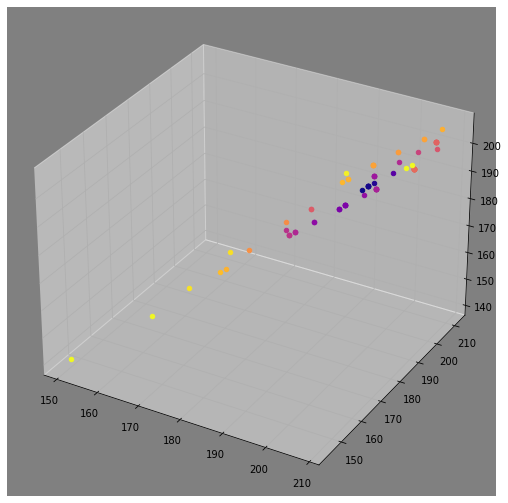

In [187]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scaler = MinMaxScaler()
pixel=1000

colors = plt.get_cmap('plasma')
scores = []
for point in stacked[pixel]:
  score = [(model[pixel].score_samples([point])[0])]
  scores.append(1-np.exp(score))

scores = scaler.fit_transform(scores)
for score, point in zip(scores, stacked[pixel]):
  color = colors(score)
  xs, ys, zs = point
  ax.set_facecolor('gray')
  ax.scatter(xs, ys, zs, color=color)
plt.show()

Here I am using the distance from the mean pixel value of a GMM to detect anomolies becuse I found that it is faster than the `score_samples` method and still gives comparable results, which you can see in the plot below when compared to the previous plot

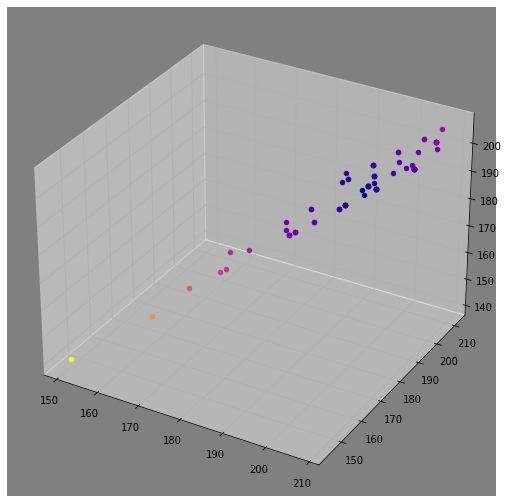

In [188]:
def distance(pt1, pt2):
  return (np.sum((pt1-pt2)**2))**0.5

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scaler = MinMaxScaler()
scores = []
for point in stacked[pixel]:
  score = distance(model[pixel].means_[0], point)
  scores.append([score])

scores = scaler.fit_transform(scores)
for score, point in zip(scores, stacked[pixel]):
  color = colors(score)
  xs, ys, zs = point
  ax.set_facecolor('gray')
  ax.scatter(xs, ys, zs, color=color)
plt.show()

By taking the mean of each GMM, we cna recostruct the background, excluding any moving objects  

In [189]:
background = np.empty((frameHeight*frameWidth, 3), np.dtype('uint8'))

for i in range(frameHeight*frameWidth):
    background[i] = np.array([*map(int, model[i].means_[0])])

background.shape

(19200, 3)

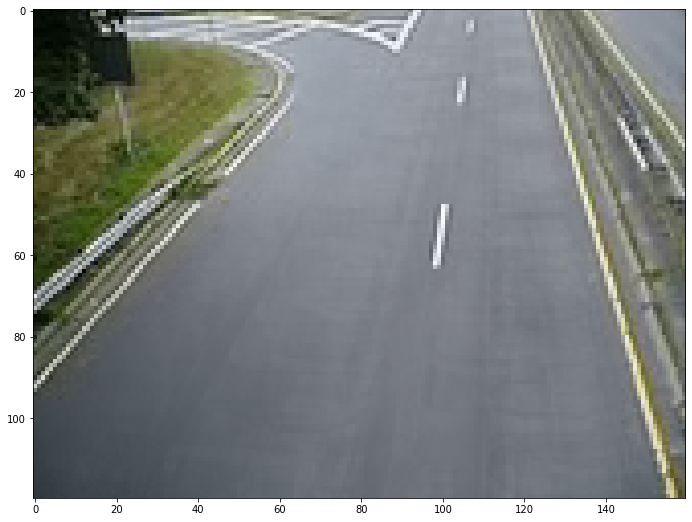

In [190]:
background = background.reshape(frameHeight, frameWidth, 3)
plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
plt.show()

Here I test out a single frame against the model to isolate movement.
I played around with several threshold values and found a distance threshold of 100 to represent anomolies yields good looking results

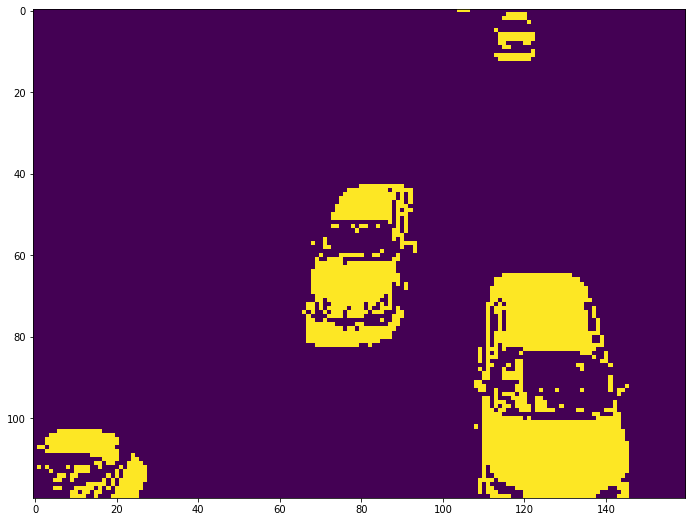

In [191]:
threshold_value = 100
movement = np.zeros((frameHeight*frameWidth, 1), np.dtype('uint8'))
frame = buf[50].reshape(frameHeight*frameWidth, 3)

for i in range(frameHeight*frameWidth):
  means = [*map(int, model[i].means_[0])]
  score = distance(means, frame[i])
  movement[i] = 0 if (score < threshold_value) else 1

movement = movement.reshape(frameHeight, frameWidth)
plt.imshow(movement)
plt.show()

Now I process the entire video

In [192]:
results = []
for j in range(frameCount):
  movement = np.zeros((frameHeight*frameWidth, 3), np.dtype('uint8'))
  frame = buf[j].reshape(frameHeight*frameWidth, 3)
  for i in range(frameHeight*frameWidth):
    means = [*map(int, model[i].means_[0])]
    score = distance(means, frame[i])
    movement[i] =  [0, 0, 0] if (score < 100) else [255, 255, 255]
  results.append(movement.reshape(frameHeight, frameWidth, 3))

In [193]:
fourcc = cv2.VideoWriter_fourcc(*'VP90')
video = cv2.VideoWriter('traffic_movement_scratch.webm', fourcc, float(fps), (frameWidth, frameHeight))
for f in results:
  video.write(f)
video.release()  

# Video('traffic_movement_scratch.webm', width=300, html_attributes="controls loop autoplay")
Video('https://github.com/dylanlrrb/dylanlrrb.github.io/blob/master/portfolio/background_removal/traffic_movement_scratch.webm?raw=true', width=300, html_attributes="controls loop autoplay")

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'
